!TODO раскидать всё по python-модулям
Данный файл служит для препроцессинга всех выбранных датасетов автомобилей. Примерная схема для итоговый директорий с автомобилями будет выглядеть так:

![image.jpg](image.jpg)



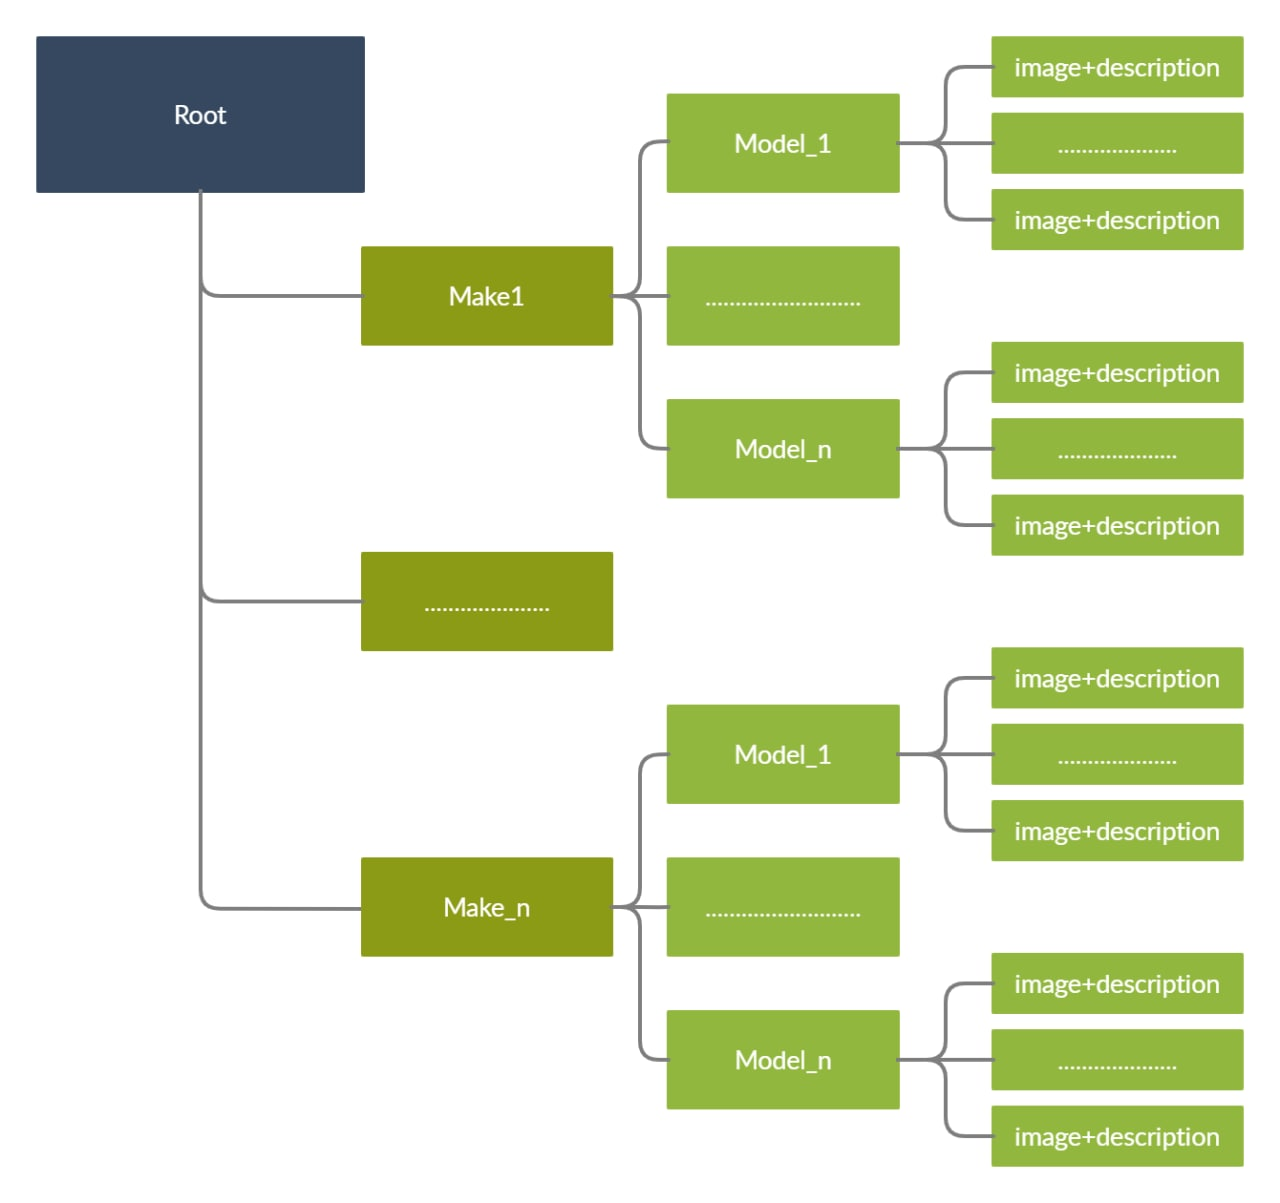

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from pathlib import Path
from scipy.io import loadmat
import fnmatch

In [3]:
some = loadmat(r"E:\University\НИР\Project\src\etl\datasets\stanford\cars_annos.mat")
some

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         ...,
         (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dt

In [4]:
some['class_names']

array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
        array(['Acura RL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Type-S 2008'], dtype='<U20'),
        array(['Acura TSX Sedan 2012'], dtype='<U20'),
        array(['Acura Integra Type R 2001'], dtype='<U25'),
        array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
        array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
        array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
        array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
        array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
        array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
        array(['Audi A5 Coupe 2012'], dtype='<U18'),
        array(['Audi TTS Coupe 2012'], dtype='<U19'),
        array(['Audi R8 Coupe 2012'], dtype='<U18'),
        array(['Audi V8 Sedan 1994'], dtype='<U18'),
        array(['Audi 100 Sedan 1994'], dtype='<U

# Stanford Cars dataset reading

In [2]:
devkit_path = Path('StanfordCarsDataset/devkit')
train_path = Path('StanfordCarsDataset/cars_train')
test_path = Path('StanfordCarsDataset/cars_test')

## DevKit

In [3]:
os.listdir(devkit_path)

['cars_meta.mat',
 'cars_test_annos.mat',
 'cars_test_annos_withlabels.mat',
 'cars_train_annos.mat',
 'eval_train.m',
 'README.txt',
 'train_perfect_preds.txt']

In [4]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')

In [5]:
with open(devkit_path/'README.txt') as f:
    for line in f:
        print(line)

This file gives documentation for the cars 196 dataset.

(http://ai.stanford.edu/~jkrause/cars/car_dataset.html)



----------------------------------------

Metadata/Annotations

----------------------------------------

Descriptions of the files are as follows:



-cars_meta.mat:

  Contains a cell array of class names, one for each class.



-cars_train_annos.mat:

  Contains the variable 'annotations', which is a struct array of length

  num_images and where each element has the fields:

    bbox_x1: Min x-value of the bounding box, in pixels

    bbox_x2: Max x-value of the bounding box, in pixels

    bbox_y1: Min y-value of the bounding box, in pixels

    bbox_y2: Max y-value of the bounding box, in pixels

    class: Integral id of the class the image belongs to.

    fname: Filename of the image within the folder of images.



-cars_test_annos.mat:

  Same format as 'cars_train_annos.mat', except the class is not provided.



----------------------------------------

Submiss

In [6]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos_withlabels.mat')

# Loading labels

Нам нужно разбить лейблы на бренд, модель и год. Главной проблемой стоит тот факт, что автомобильный бренд не всегда состоит из одного слова. Поэтому в любом случае придётся прибегнуть к доделыванию данных за алгоритмом.

Решением выбрано создание отдельного файла с брендами, где указаны альтернативные названия каждого бренда. В таком случае, если мы встретим, например, Land Rover, то мы найдём бренд Land и сможем дополнить его до Land Rover.

In [7]:
multi_word_brands = pd.read_csv("multi_words_brands.csv")
multi_word_brands_correction = {brand.split()[0]:brand for brand in multi_word_brands['name']}
multi_word_brands_correction

{'Aston': 'Aston Martin',
 'Alfa': 'Alfa Romeo',
 'Land': 'Land Rover',
 'AM': 'AM General'}

In [8]:
cars_meta['class_names']

array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
        array(['Acura RL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Type-S 2008'], dtype='<U20'),
        array(['Acura TSX Sedan 2012'], dtype='<U20'),
        array(['Acura Integra Type R 2001'], dtype='<U25'),
        array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
        array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
        array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
        array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
        array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
        array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
        array(['Audi A5 Coupe 2012'], dtype='<U18'),
        array(['Audi TTS Coupe 2012'], dtype='<U19'),
        array(['Audi R8 Coupe 2012'], dtype='<U18'),
        array(['Audi V8 Sedan 1994'], dtype='<U18'),
        array(['Audi 100 Sedan 1994'], dtype='<U

In [9]:
labels = {'brand':[], 'model':[], 'year':[]}
for class_name in cars_meta['class_names'][0]:
    class_name_list = class_name[0].split()
    brand = class_name_list[0]
    if brand in multi_word_brands_correction:
        brand = multi_word_brands_correction[brand]
        model = ' '.join(class_name_list[2:-1])
    else:
        model = ' '.join(class_name_list[1:-1])
    year = class_name_list[-1]
    
    labels['brand'].append(brand)
    labels['model'].append(model)
    labels['year'].append(year)
labels = pd.DataFrame(labels)
labels

,brand,model,year
0,AM General,Hummer SUV,2000
1,Acura,RL Sedan,2012
2,Acura,TL Sedan,2012
3,Acura,TL Type-S,2008
4,Acura,TSX Sedan,2012
...,...,...,...
191,Volkswagen,Beetle Hatchback,2012
192,Volvo,C30 Hatchback,2012
193,Volvo,240 Sedan,1993
194,Volvo,XC90 SUV,2007


# Loading cars train

In [10]:
frame = [[i.flat[0] for i in line][4:] for line in cars_train_annos['annotations'][0]]
columns = ['class', 'fname']
frame[0][0] = int(frame[0][0]) # change dtype of class to prevent numeric overflow 
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
print(df_train.dtypes)
df_train.head()

class     int64
fname    object
dtype: object


,class,fname
0,13,StanfordCarsDataset\cars_train\00001.jpg
1,2,StanfordCarsDataset\cars_train\00002.jpg
2,90,StanfordCarsDataset\cars_train\00003.jpg
3,133,StanfordCarsDataset\cars_train\00004.jpg
4,105,StanfordCarsDataset\cars_train\00005.jpg


# Merging labels

In [11]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,class,fname,brand,model,year
0,13,StanfordCarsDataset\cars_train\00001.jpg,Audi,TTS Coupe,2012
1,2,StanfordCarsDataset\cars_train\00002.jpg,Acura,TL Sedan,2012
2,90,StanfordCarsDataset\cars_train\00003.jpg,Dodge,Dakota Club Cab,2007
3,133,StanfordCarsDataset\cars_train\00004.jpg,Hyundai,Sonata Hybrid Sedan,2012
4,105,StanfordCarsDataset\cars_train\00005.jpg,Ford,F-450 Super Duty Crew Cab,2012


# Loading cars test

В данном датасете первоначально отсутствуют классы для тестовой части, их пришлось скачать отдельно с официального сайта данного набора данных. Поэтому временно пропускаем изображения, относящиеся к тестовой части.

In [12]:
frame = [[i.flat[0] for i in line][4:] for line in cars_test_annos['annotations'][0]]
frame[0][0] = int(frame[0][0])
columns = ['class', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path/f for f in df_test['fname']] #  Appending Path
df_test.head()

,class,fname
0,181,StanfordCarsDataset\cars_test\00001.jpg
1,103,StanfordCarsDataset\cars_test\00002.jpg
2,145,StanfordCarsDataset\cars_test\00003.jpg
3,187,StanfordCarsDataset\cars_test\00004.jpg
4,185,StanfordCarsDataset\cars_test\00005.jpg


In [13]:
df_test = df_test.merge(labels, left_on='class', right_index=True)
df_test = df_test.sort_index()
df_test.head()

,class,fname,brand,model,year
0,181,StanfordCarsDataset\cars_test\00001.jpg,Suzuki,Kizashi Sedan,2012
1,103,StanfordCarsDataset\cars_test\00002.jpg,Ferrari,458 Italia Coupe,2012
2,145,StanfordCarsDataset\cars_test\00003.jpg,Jeep,Wrangler SUV,2012
3,187,StanfordCarsDataset\cars_test\00004.jpg,Toyota,Corolla Sedan,2012
4,185,StanfordCarsDataset\cars_test\00005.jpg,Toyota,Sequoia SUV,2012


# Displaying image 

In [16]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    image = Image.open(df['fname'][i])
    title = df['brand'][i]+' '+df['model'][i]
    
    return (image, title)

In [17]:
def display_image(df, i):
    image, title = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

Ferrari 458 Italia Coupe


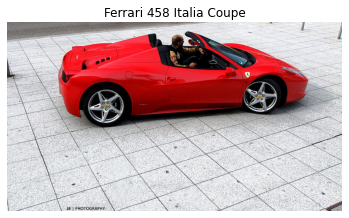

In [18]:
display_image(df_test, 1)

In [19]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        
        im, title = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        
    plt.show()

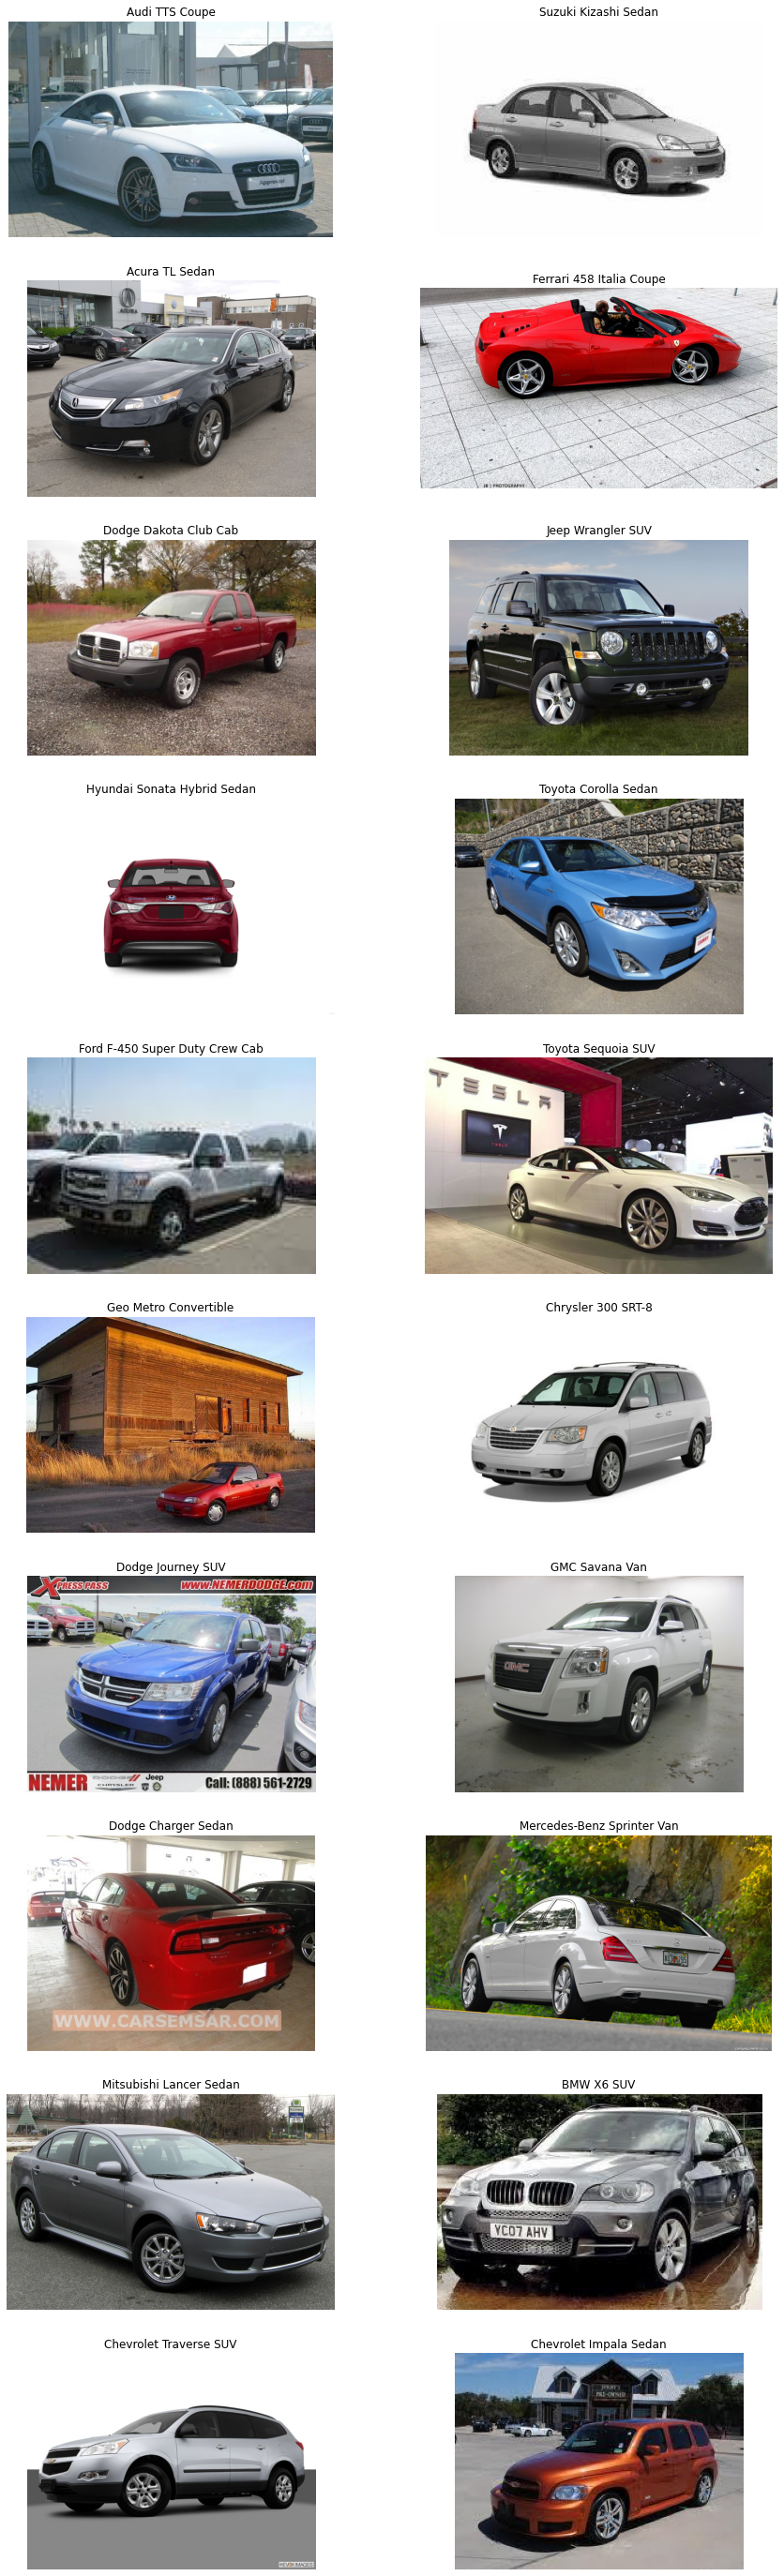

In [20]:
display_range(10)

# Shard creation
После того, как мы сделали всю предобработку данных, можно приступить к формированию датасета с единой структурой:

Перейдём к директории с датасетом

In [14]:
import os

In [15]:
os.getcwd()

'E:\\Text2CarsGeneration\\Text2CarsGeneration\\RawDatasetsPreprocessing'

In [16]:
os.chdir('..\\CarDataset')
os.getcwd()

'E:\\Text2CarsGeneration\\Text2CarsGeneration\\CarDataset'

Создаём папки для каждой модели:

In [19]:
def copy_to_general_dataset(df, i):
    image = cv2.imread('..\\RawDatasetsPreprocessing\\'+str(df['fname'][i]))
    image = cv2.resize(image, (256,256))
    brand = df['brand'][i]
    model = df['model'][i] + ' ' + df['year'][i]
    os.makedirs(f"{brand}/{model}", exist_ok=True)
    index = len(fnmatch.filter(os.listdir(f"{brand}/{model}/"), '*.jpg'))
    cv2.imwrite(f"{brand}/{model}/{index}.jpg", image)

In [20]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)
df

,class,fname,brand,model,year
0,13,StanfordCarsDataset\cars_train\00001.jpg,Audi,TTS Coupe,2012
1,2,StanfordCarsDataset\cars_train\00002.jpg,Acura,TL Sedan,2012
2,90,StanfordCarsDataset\cars_train\00003.jpg,Dodge,Dakota Club Cab,2007
3,133,StanfordCarsDataset\cars_train\00004.jpg,Hyundai,Sonata Hybrid Sedan,2012
4,105,StanfordCarsDataset\cars_train\00005.jpg,Ford,F-450 Super Duty Crew Cab,2012
...,...,...,...,...,...
16140,63,StanfordCarsDataset\cars_test\08037.jpg,Chevrolet,Express Cargo Van,2007
16141,16,StanfordCarsDataset\cars_test\08038.jpg,Audi,100 Sedan,1994
16142,17,StanfordCarsDataset\cars_test\08039.jpg,Audi,100 Wagon,1994
16143,38,StanfordCarsDataset\cars_test\08040.jpg,Bentley,Continental Supersports Conv. Convertible,2012


In [21]:
for i in range(len(df)):
    copy_to_general_dataset(df, i)

# CompCars Dataset
## Web nature data

Нам не нужен тип автомобиля, количество его дверей, колёс и другого. Поэтому загружаем только make_model_name.mat

Изображения хранятся по такому пути: make_id/model_id/released_year/image_name.jpg

In [22]:
compcars_make_model_name = loadmat(r"../RawDatasetsPreprocessing/CompCars/data/misc/make_model_name.mat")
compcars_make_names = compcars_make_model_name['make_names']
compcars_model_names = compcars_make_model_name['model_names']

In [23]:
make_names_dict = {}
counter = 1
for make_name in compcars_make_names:
    make_names_dict[counter] = make_name[0][0]
    counter += 1
print(make_names_dict)

{1: 'ABT', 2: 'BAC', 3: 'Conquest', 4: 'DS', 5: 'Dacia', 6: 'Fisker', 7: 'GMC', 8: 'Gumpert', 9: 'Hennessey', 10: 'Icona', 11: 'Jeep', 12: 'KTM', 13: 'MELKUS', 14: 'MG', 15: 'MINI', 16: 'Mazzanti', 17: 'Noble', 18: 'PGO', 19: 'SPIRRA', 20: 'SSC', 21: 'Scion', 22: 'TESLA', 23: 'TVR', 24: 'Tramontana', 25: 'Zenvo', 26: 'smart', 27: 'Yiqi', 28: 'Mitsubishi', 29: 'Shangqidatong', 30: 'Spyker N.V.', 31: 'Dongnan', 32: 'Dongfeng', 33: 'Dongfengxiaokang', 34: 'Dongfengfengdu', 35: 'Dongfengfengshen', 36: 'Dongfengfengxing', 37: 'Zxauto', 38: 'Zhonghua', 39: 'Toyota', 40: 'Zinoro', 41: 'Jiulong', 42: 'Isuzu', 43: 'Wuling', 44: 'AC Chnitzer', 45: 'Zoyte', 46: 'Iveco', 47: 'Bufori', 48: 'Porsche', 49: 'Mitsuoka', 50: 'Chrysler', 51: 'Lamorghini ', 52: 'Kombat', 53: 'Cadillac', 54: 'Buck', 55: 'Lifan', 56: 'Lorinser', 57: 'Rolls-Royce', 58: 'BAW', 59: 'Baihc', 60: 'Beiqiweiwang', 61: 'Beiqihuansu', 62: 'Beiqi New Energy', 63: 'Huapu', 64: 'Huatai', 65: 'Huaqi', 66: 'Carlsson', 67: 'Shuanghuan', 6

In [24]:
model_names_dict = {}
counter = 1
for model_name in compcars_model_names:
    if len(model_name[0]):
        model_names_dict[counter] = model_name[0][0]
    counter+=1
model_names_dict

{1: 'Audi A3 hatchback',
 2: 'Audi A4L',
 3: 'Audi A6L',
 4: 'Audi Q3',
 5: 'Audi Q5',
 9: 'Audi A6',
 11: 'Audi A3 sedan',
 12: 'Audi RS5',
 13: 'Audi RS7',
 14: 'Audi RS4',
 15: 'Audi RS Q3',
 16: 'Audi RS3',
 17: 'Audi TT RS',
 18: 'Audi RS6',
 19: 'Audi A1',
 21: 'Audi A4 estate',
 22: 'Audi A5 convertible',
 23: 'Audi A5 coupe',
 24: 'Audi A5 hatchback',
 25: 'Audi A6 hybrid',
 26: 'Audi A7',
 27: 'Audi A8L',
 28: 'Audi A8L hybrid',
 31: 'Audi Q5 hybrid',
 32: 'Audi Q7',
 33: 'Audi R8',
 34: 'Audi S5 convertible',
 35: 'Audi S5 coupe',
 36: 'Audi S5 hatchback',
 38: 'Audi S7',
 39: 'Audi S8',
 40: 'Audi SQ5',
 41: 'Audi TTS convertible',
 42: 'Audi TTS coupe',
 43: 'Audi TT convertible',
 44: 'Audi TT coupe',
 46: 'Audi A2',
 47: 'Audi quattro',
 48: 'Audi Urban',
 49: 'Audi Cross',
 50: 'Audi e-tron',
 52: 'Audi S3 hatchback',
 53: 'Audi R18',
 55: 'Audi A3 convertible',
 56: 'Audi A3 e-tron',
 57: 'Audi S1',
 60: 'Allroad',
 61: 'Crosslane Coupe',
 62: 'Audi S3 sedan',
 63: 'Aud

In [25]:
directory = r"..\RawDatasetsPreprocessing\CompCars\data\image"
compcars_dicts = []
for root, subdirectories, files in os.walk(directory):
    for file in files:
        row = {'fname': None, 'brand': None, 'model': None, 'year': None}
        row['fname'] = os.path.join(root, file)[28:]
        make_id, model_id, year = root.split('\\')[-3:]
        row['brand'] = make_names_dict[int(make_id)].strip()
        row['model'] = model_names_dict[int(model_id)].replace(row['brand'],'').strip()
        row['year'] = year.strip()
        compcars_dicts.append(row)
print(compcars_dicts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
compcars_dicts

[{'fname': 'CompCars\\data\\image\\1\\1101\\2011\\07b90decb92ba6.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\2272c7d324cf79.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\3a62131af5fe8e.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\5133ca181b82af.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\6632ec1c2f7f87.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\67c264ccb6f982.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\7a6282504fdd2c.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},
 {'fname': 'CompCars\\data\\image\\1\\1101\\2011\\8a8a9bc65fab0b.jpg',
  'brand': 'ABT',
  'model': 'A3',
  'year': '2011'},


In [27]:
df = pd.DataFrame(compcars_dicts)

In [28]:
for i in range(len(df)):
    copy_to_general_dataset(df, i)

## Survialance nature data

Не содержит года выпуска, поэтому пока откладываем обработку этих данных

# DVM-Car

In [ ]:
# TODO